## Building Models

### Imports and Defaults

In [161]:
import pandas                as pd
import numpy                 as np
import tensorflow            as tf
import lightgbm              as lgbm
import seaborn               as sns
import matplotlib.pyplot     as plt
import statsmodels.api       as sm
import tensorflow            as tf
import math

from statsmodels.formula.api import logit

from sklearn                 import metrics
from sklearn.metrics         import plot_confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble        import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing   import StandardScaler
from sklearn.utils           import resample 
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors       import KNeighborsClassifier

from tensorflow              import keras
from tensorflow.keras        import layers

from pylab                   import rcParams

from keras.models            import Sequential
from keras.layers            import Dense




%matplotlib inline
rcParams['figure.figsize']  = 15, 10
rcParams['axes.titlesize']  = 20
rcParams['axes.labelsize']  = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size']       = 18

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [162]:
relations                  = pd.read_csv('Metrics\\DataSet\\workingDataset.csv', index_col=0, dtype={'Tagged_Relationship': 'int8'})
col_to_downcast            = [col for col in relations.columns if relations[col].dtype==int]
relations[col_to_downcast] = relations[col_to_downcast].apply(pd.to_numeric, downcast='integer')

cols            = list(relations.columns)
cols.remove('Tagged_Relationship')
cols.append('Tagged_Relationship')
relations       = relations[cols]

## Select Possible Features

<AxesSubplot:>

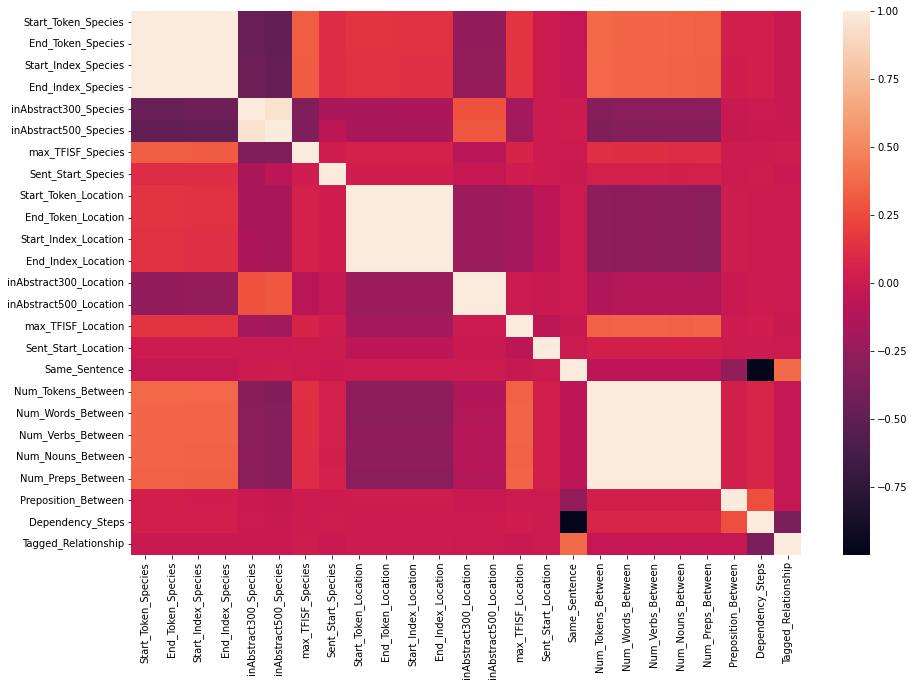

In [163]:
corr = relations.corr()
sns.heatmap(corr)

In [164]:
features_all = ['inAbstract300_Species', 
                'inAbstract500_Species', 
                'max_TFISF_Species',
                'Sent_Start_Species', 
                'inAbstract300_Location', 
                'inAbstract500_Location',
                'max_TFISF_Location', 
                'Sent_Start_Location', 
                'Same_Sentence',
                'Num_Tokens_Between', 
                'Num_Words_Between', 
                'Num_Verbs_Between',
                'Num_Nouns_Between',
                'Num_Preps_Between', 
                'Preposition_Between',
                'Dependency_Steps',
                'sqrt_max_TFISF_Species', 
                'sqrt_max_TFISF_Location',
                'sqrt_Num_Tokens_Between', 
                'sqrt_Num_Words_Between',
                'sqrt_Num_Verbs_Between', 
                'sqrt_Num_Nouns_Between',
                'sqrt_Num_Preps_Between', 
                'log_max_TFISF_Species',
                'log_max_TFISF_Location', 
                'log_Num_Verbs_Between']

features_all = ['inAbstract300_Species', 
                'inAbstract500_Species', 
                'max_TFISF_Species',
                'Sent_Start_Species', 
                'inAbstract300_Location', 
                'inAbstract500_Location',
                'max_TFISF_Location', 
                'Sent_Start_Location', 
                'Same_Sentence',
                'Num_Tokens_Between', 
                'Num_Words_Between', 
                'Num_Verbs_Between',
                'Num_Nouns_Between',
                'Num_Preps_Between', 
                'Preposition_Between',
                'Dependency_Steps']

features_cat = ['inAbstract300_Species', 
                'inAbstract500_Species', 
                'Sent_Start_Species', 
                'inAbstract300_Location', 
                'inAbstract500_Location', 
                'Sent_Start_Location', 
                'Same_Sentence', 
                'Preposition_Between']

features_raw = features_all[:16]

In [165]:
y = relations.Tagged_Relationship

In [166]:
X = relations[features_all]

sqrt_max_TFISF_Species               = [math.sqrt(x) for x in relations['max_TFISF_Species']]
relations['sqrt_max_TFISF_Species']  = sqrt_max_TFISF_Species

sqrt_max_TFISF_Location              = [math.sqrt(x) for x in relations['max_TFISF_Location']]
relations['sqrt_max_TFISF_Location'] = sqrt_max_TFISF_Location

sqrt_Num_Tokens_Between              = [math.sqrt(x) for x in relations['Num_Tokens_Between']]
relations['sqrt_Num_Tokens_Between'] = sqrt_Num_Tokens_Between

sqrt_Num_Words_Between               = [math.sqrt(x) for x in relations['Num_Words_Between']]
relations['sqrt_Num_Words_Between']  = sqrt_Num_Words_Between

sqrt_Num_Verbs_Between               = [math.sqrt(x) for x in relations['Num_Verbs_Between']]
relations['sqrt_Num_Verbs_Between']  = sqrt_Num_Verbs_Between

sqrt_Num_Nouns_Between               = [math.sqrt(x) for x in relations['Num_Nouns_Between']]
relations['sqrt_Num_Nouns_Between']  = sqrt_Num_Nouns_Between

sqrt_Num_Preps_Between               = [math.sqrt(x) for x in relations['Num_Preps_Between']]
relations['sqrt_Num_Preps_Between']  = sqrt_Num_Preps_Between

log_max_TFISF_Species                = [math.log(x) if x > 0 else 0 for x in relations['max_TFISF_Species']]
relations['log_max_TFISF_Species']   = log_max_TFISF_Species

log_max_TFISF_Location               = [math.log(x) if x > 0 else 0 for x in relations['max_TFISF_Location']]
relations['log_max_TFISF_Location']  = log_max_TFISF_Location

log_Num_Verbs_Between                = [math.log(x) if x > 0 else 0 for x in relations['Num_Verbs_Between']]
relations['log_Num_Verbs_Between']   = log_Num_Verbs_Between

## Test / Train Split

In [167]:
x = relations[features_all + ['Document', 'Tagged_Relationship']]

In [168]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    x['Tagged_Relationship'], 
                                                    test_size    = 0.3,
                                                    random_state = 0, 
                                                    shuffle      = True,
                                                    stratify     = x[['Document', 'Tagged_Relationship']])
train                = x_train.copy()
x_train.drop(columns = ['Document', 'Tagged_Relationship'], inplace=True)
x_test_with_document = x_test.copy()
x_test.drop(columns  = ['Document', 'Tagged_Relationship'], inplace=True)

In [169]:
print('Size of training sets:', len(x_train), len(y_train))
print('Size of test sets:', len(x_test), len(y_test))

Size of training sets: 45967 45967
Size of test sets: 19701 19701


In [170]:
y_train.value_counts()

0    45937
1       30
Name: Tagged_Relationship, dtype: int64

In [171]:
y_test.value_counts()

0    19689
1       12
Name: Tagged_Relationship, dtype: int64

## Models

### Adaboost

In [172]:
adaboost_clf = AdaBoostClassifier(random_state=0)

In [173]:
adaboost_clf.fit(x_train[features_raw], y_train)

AdaBoostClassifier(random_state=0)

In [174]:
y_pred_adaboost = adaboost_clf.predict(x_test[features_raw])

In [175]:
print(metrics.classification_report(y_test, y_pred_adaboost))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19689
           1       0.44      0.33      0.38        12

    accuracy                           1.00     19701
   macro avg       0.72      0.67      0.69     19701
weighted avg       1.00      1.00      1.00     19701



In [176]:
print(metrics.confusion_matrix(y_test, y_pred_adaboost))

[[19684     5]
 [    8     4]]


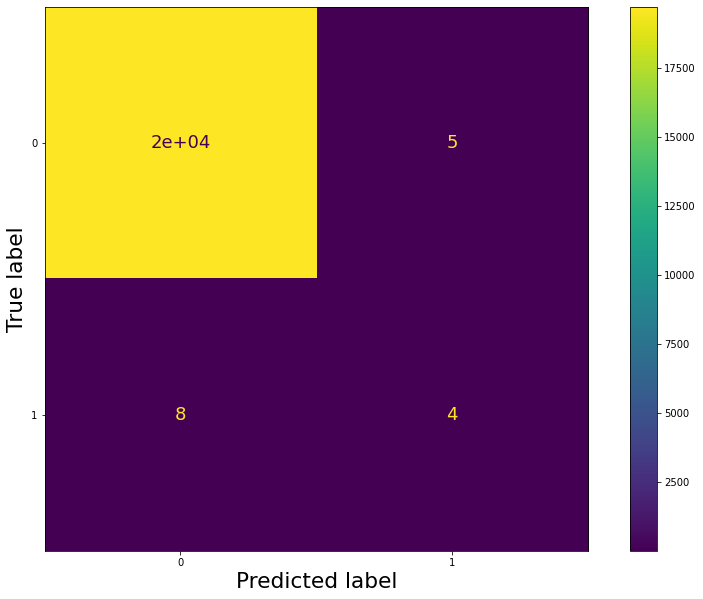

In [177]:
plot_confusion_matrix(adaboost_clf, x_test[features_raw], y_test)

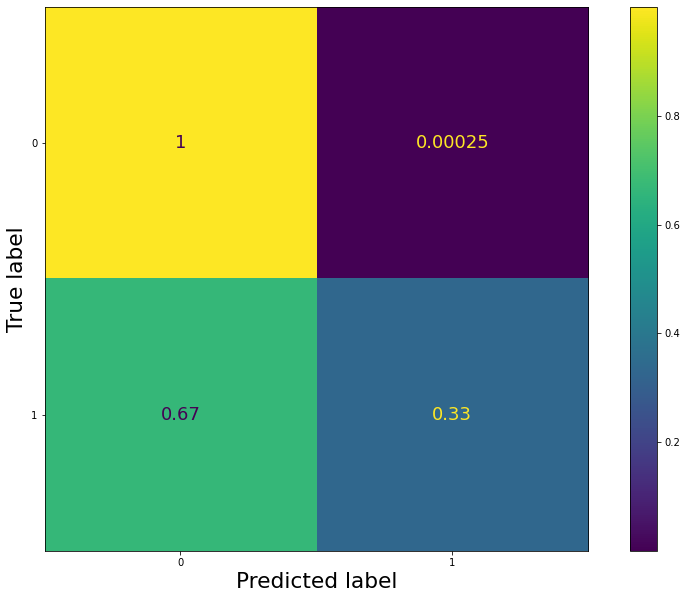

In [178]:
plot_confusion_matrix(adaboost_clf, x_test[features_raw], y_test, normalize='true')

In [179]:
pd.DataFrame(sorted(list(zip(features_raw, adaboost_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns = ['Feature', 'Importance'])

,Feature,Importance
0,Num_Tokens_Between,0.18
1,Num_Verbs_Between,0.16
2,max_TFISF_Species,0.14
3,max_TFISF_Location,0.12
4,Num_Words_Between,0.12
5,Num_Nouns_Between,0.08
6,Dependency_Steps,0.08
7,Num_Preps_Between,0.06
8,inAbstract500_Species,0.02
9,Same_Sentence,0.02


In [180]:
top_abst_features    = list(pd.DataFrame(sorted(list(zip(features_all, adaboost_clf.feature_importances_)), 
                            key     = lambda x:x[1], 
                            reverse = True), 
                            columns = ['Feature', 'Importance'])['Feature'][:10])
top_abst_features

['Num_Tokens_Between',
 'Num_Verbs_Between',
 'max_TFISF_Species',
 'max_TFISF_Location',
 'Num_Words_Between',
 'Num_Nouns_Between',
 'Dependency_Steps',
 'Num_Preps_Between',
 'inAbstract500_Species',
 'Same_Sentence']

### Light Gradient Boosting Machine (LGBM)

In [181]:
lgbm_clf = lgbm.LGBMClassifier(random_state=0)

In [182]:
lgbm_clf.fit(x_train[features_raw], y_train)

LGBMClassifier(random_state=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

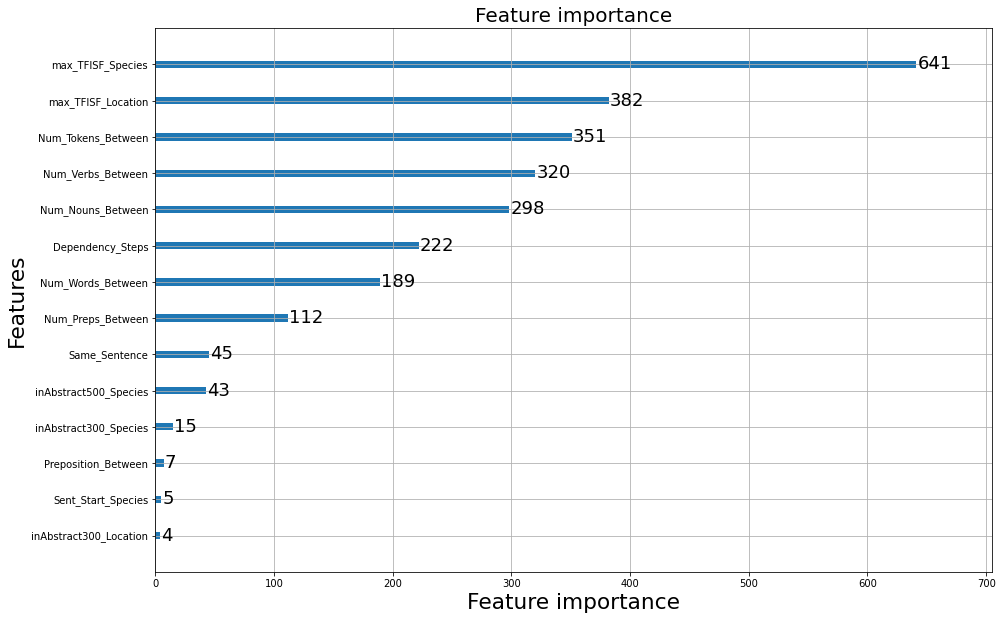

In [183]:
lgbm.plot_importance(lgbm_clf)

In [184]:
lgbm_feat_imp = pd.DataFrame(sorted(list(zip(features_raw, lgbm_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])
lgbm_feat_imp['Normalised']= lgbm_feat_imp.Importance / lgbm_feat_imp.Importance.sum() 

In [185]:
lgbm_feat_imp

,Feature,Importance,Normalised
0,max_TFISF_Species,641,0.243356
1,max_TFISF_Location,382,0.145027
2,Num_Tokens_Between,351,0.133257
3,Num_Verbs_Between,320,0.121488
4,Num_Nouns_Between,298,0.113136
5,Dependency_Steps,222,0.084282
6,Num_Words_Between,189,0.071754
7,Num_Preps_Between,112,0.042521
8,Same_Sentence,45,0.017084
9,inAbstract500_Species,43,0.016325


In [186]:
top_lgbm_features = list(pd.DataFrame(sorted(list(zip(features_raw, lgbm_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])['Feature'][:14])
top_lgbm_features

['max_TFISF_Species',
 'max_TFISF_Location',
 'Num_Tokens_Between',
 'Num_Verbs_Between',
 'Num_Nouns_Between',
 'Dependency_Steps',
 'Num_Words_Between',
 'Num_Preps_Between',
 'Same_Sentence',
 'inAbstract500_Species',
 'inAbstract300_Species',
 'Preposition_Between',
 'Sent_Start_Species',
 'inAbstract300_Location']

In [187]:
y_pred_lgbm = lgbm_clf.predict(x_test[features_raw])

In [188]:
print(metrics.classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19689
           1       0.29      0.42      0.34        12

    accuracy                           1.00     19701
   macro avg       0.65      0.71      0.67     19701
weighted avg       1.00      1.00      1.00     19701



In [189]:
print(metrics.confusion_matrix(y_test, y_pred_lgbm))

[[19677    12]
 [    7     5]]


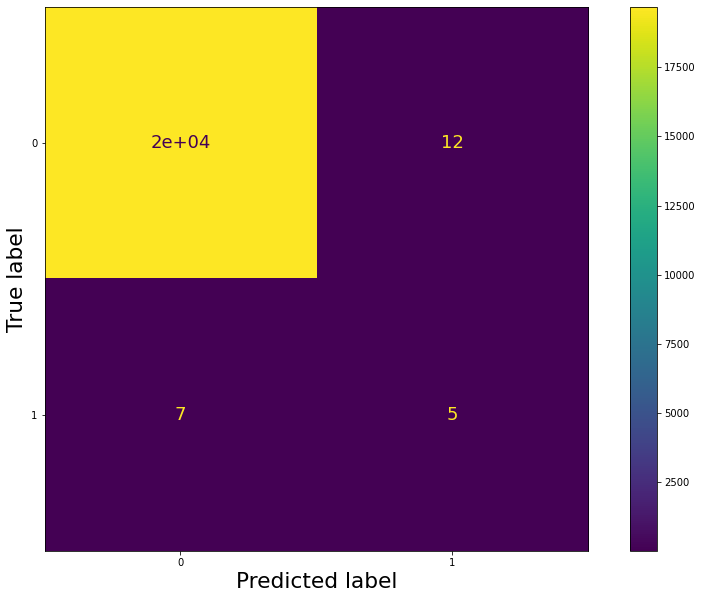

In [190]:
plot_confusion_matrix(lgbm_clf, x_test[features_raw], y_test)

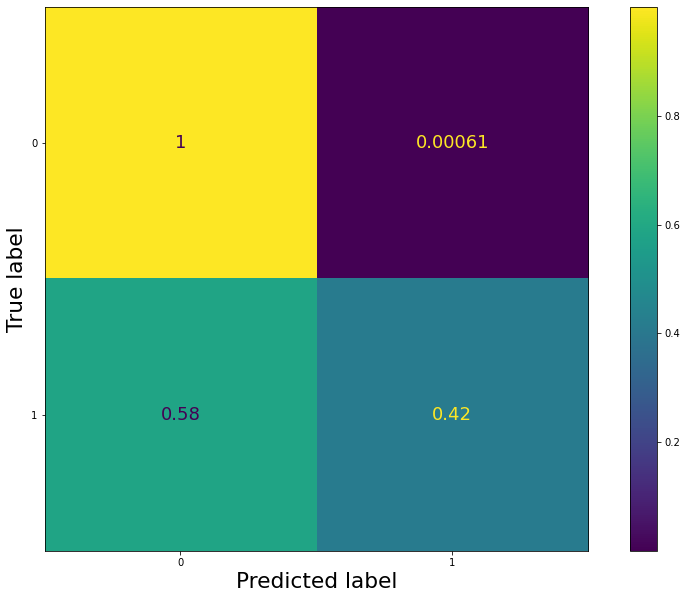

In [191]:
plot_confusion_matrix(lgbm_clf, x_test[features_raw], y_test, normalize='true')

### Random Forest Classifier

In [192]:
rf_clf = RandomForestClassifier(random_state=0)

In [193]:
rf_clf.fit(x_train[features_raw], y_train)

RandomForestClassifier(random_state=0)

In [194]:
pd.DataFrame(sorted(list(zip(features_raw, rf_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])

,Feature,Importance
0,max_TFISF_Species,0.145378
1,Num_Tokens_Between,0.140732
2,Num_Words_Between,0.135077
3,Num_Nouns_Between,0.117577
4,Dependency_Steps,0.115727
5,max_TFISF_Location,0.112298
6,Num_Verbs_Between,0.065642
7,Num_Preps_Between,0.061003
8,Same_Sentence,0.041419
9,inAbstract500_Species,0.030511


In [195]:
top_rf_features = list(pd.DataFrame(sorted(list(zip(features_raw, rf_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])['Feature'][:10])
top_rf_features

['max_TFISF_Species',
 'Num_Tokens_Between',
 'Num_Words_Between',
 'Num_Nouns_Between',
 'Dependency_Steps',
 'max_TFISF_Location',
 'Num_Verbs_Between',
 'Num_Preps_Between',
 'Same_Sentence',
 'inAbstract500_Species']

In [196]:
y_pred_rf = rf_clf.predict(x_test[features_raw])

In [197]:
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19689
           1       0.50      0.33      0.40        12

    accuracy                           1.00     19701
   macro avg       0.75      0.67      0.70     19701
weighted avg       1.00      1.00      1.00     19701



In [198]:
print(metrics.confusion_matrix(y_test, y_pred_rf))

[[19685     4]
 [    8     4]]


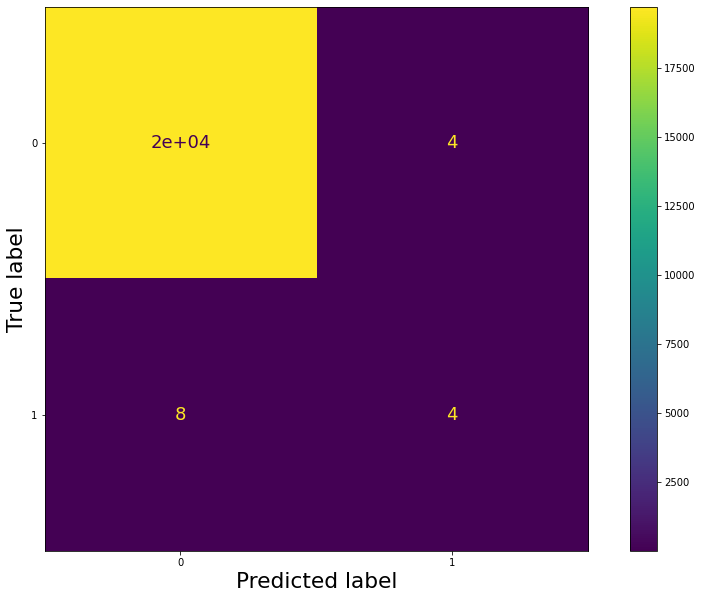

In [199]:
plot_confusion_matrix(rf_clf, x_test[features_raw], y_test)

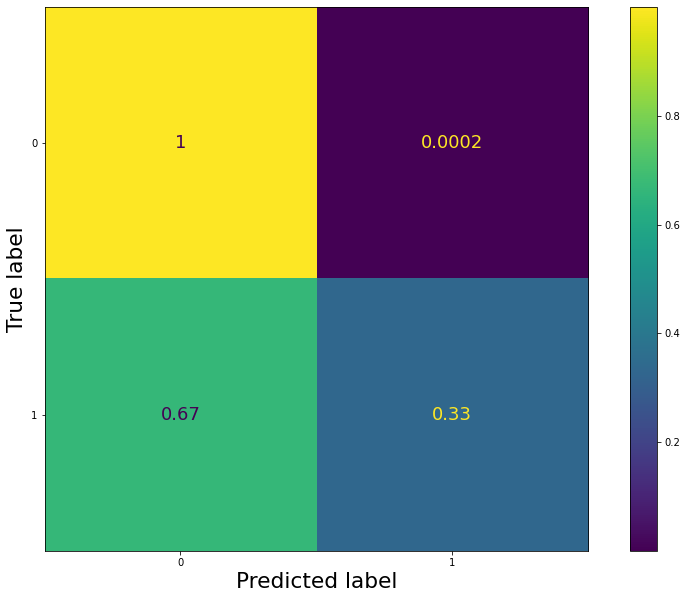

In [200]:
plot_confusion_matrix(rf_clf, x_test[features_raw], y_test, normalize='true')

### Extra Randomised Trees

In [201]:
xt_clf = ExtraTreesClassifier(random_state=0)

In [202]:
xt_clf.fit(x_train[features_raw], y_train)

ExtraTreesClassifier(random_state=0)

In [203]:
pd.DataFrame(sorted(list(zip(features_raw, xt_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])

,Feature,Importance
0,Dependency_Steps,0.136461
1,max_TFISF_Species,0.122309
2,Num_Tokens_Between,0.120048
3,Num_Nouns_Between,0.116813
4,Num_Words_Between,0.107665
5,max_TFISF_Location,0.107410
6,Num_Verbs_Between,0.078660
7,Same_Sentence,0.075397
8,Num_Preps_Between,0.065826
9,inAbstract500_Species,0.032193


In [204]:
top_et_features = list(pd.DataFrame(sorted(list(zip(features_raw, xt_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])['Feature'][:10])
top_et_features

['Dependency_Steps',
 'max_TFISF_Species',
 'Num_Tokens_Between',
 'Num_Nouns_Between',
 'Num_Words_Between',
 'max_TFISF_Location',
 'Num_Verbs_Between',
 'Same_Sentence',
 'Num_Preps_Between',
 'inAbstract500_Species']

In [205]:
y_pred_xt = xt_clf.predict(x_test[features_raw])

In [206]:
print(metrics.classification_report(y_test, y_pred_xt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19689
           1       0.45      0.42      0.43        12

    accuracy                           1.00     19701
   macro avg       0.73      0.71      0.72     19701
weighted avg       1.00      1.00      1.00     19701



In [207]:
print(metrics.confusion_matrix(y_test, y_pred_xt))

[[19683     6]
 [    7     5]]


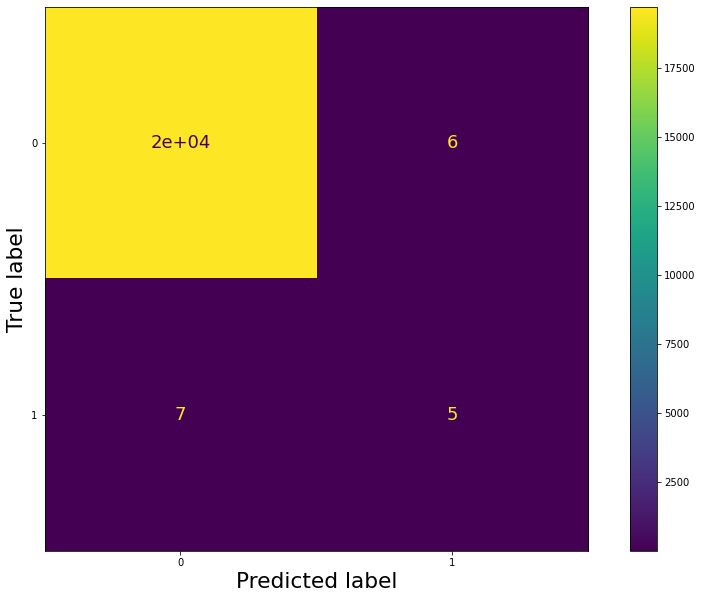

In [208]:
plot_confusion_matrix(xt_clf, x_test[features_raw], y_test)

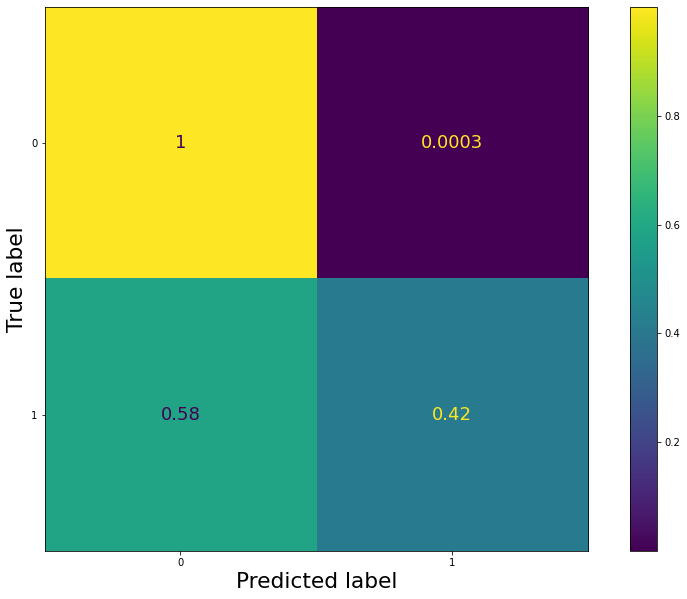

In [209]:
plot_confusion_matrix(xt_clf, x_test[features_raw], y_test, normalize='true')

### Logistic Regression

In [210]:
logReg_clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='')

In [211]:
logReg_clf.fit(x_train[features_all], y_train)

LogisticRegression(class_weight='', random_state=0, solver='liblinear')

In [212]:
y_pred_logReg = logReg_clf.predict(x_test[features_all])

In [213]:
print(metrics.classification_report(y_test, y_pred_logReg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19689
           1       0.67      0.17      0.27        12

    accuracy                           1.00     19701
   macro avg       0.83      0.58      0.63     19701
weighted avg       1.00      1.00      1.00     19701



In [214]:
print(metrics.confusion_matrix(y_test, y_pred_logReg))

[[19688     1]
 [   10     2]]


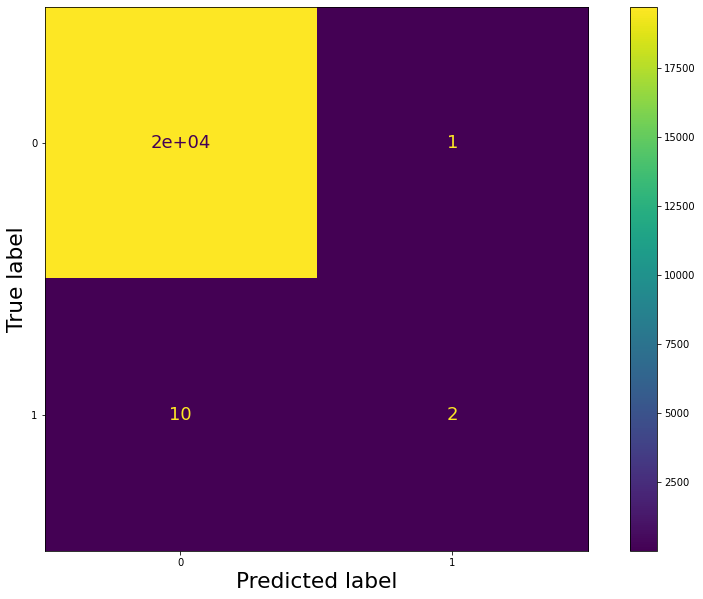

In [215]:
plot_confusion_matrix(logReg_clf, x_test, y_test)

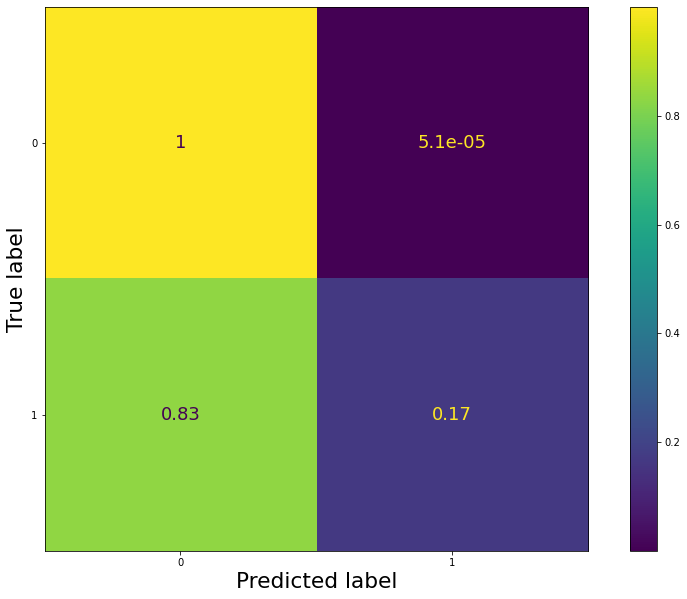

In [216]:
plot_confusion_matrix(logReg_clf, x_test, y_test, normalize='true')

In [217]:
features_all

['inAbstract300_Species',
 'inAbstract500_Species',
 'max_TFISF_Species',
 'Sent_Start_Species',
 'inAbstract300_Location',
 'inAbstract500_Location',
 'max_TFISF_Location',
 'Sent_Start_Location',
 'Same_Sentence',
 'Num_Tokens_Between',
 'Num_Words_Between',
 'Num_Verbs_Between',
 'Num_Nouns_Between',
 'Num_Preps_Between',
 'Preposition_Between',
 'Dependency_Steps']

In [218]:
feats_logReg = features_all.copy()
for item in ['inAbstract300_Species', 
             'inAbstract500_Species',  
             'inAbstract300_Location',
             'inAbstract500_Location', 
             'sqrt_Num_Tokens_Between', 
             'Preposition_Between', 
             'sqrt_max_TFISF_Species',
            'log_max_TFISF_Species', 
             'Sent_Start_Species',
             'sqrt_Num_Verbs_Between',
             'max_TFISF_Species',
             'log_Num_Verbs_Between',
             'sqrt_Num_Nouns_Between']:
    
    if item in feats_logReg:
        feats_logReg.remove(item)
    
feats_logReg

['max_TFISF_Location',
 'Sent_Start_Location',
 'Same_Sentence',
 'Num_Tokens_Between',
 'Num_Words_Between',
 'Num_Verbs_Between',
 'Num_Nouns_Between',
 'Num_Preps_Between',
 'Dependency_Steps']

In [219]:
logReg_mod_formula = "Tagged_Relationship ~ "

for feat in feats_logReg[:-1]:
    logReg_mod_formula = logReg_mod_formula + feat + ' + '
    
logReg_mod_formula = logReg_mod_formula + feats_logReg[-1]
logReg_mod_formula

'Tagged_Relationship ~ max_TFISF_Location + Sent_Start_Location + Same_Sentence + Num_Tokens_Between + Num_Words_Between + Num_Verbs_Between + Num_Nouns_Between + Num_Preps_Between + Dependency_Steps'

In [220]:
x_train

,inAbstract300_Species,inAbstract500_Species,max_TFISF_Species,Sent_Start_Species,inAbstract300_Location,inAbstract500_Location,max_TFISF_Location,Sent_Start_Location,Same_Sentence,Num_Tokens_Between,Num_Words_Between,Num_Verbs_Between,Num_Nouns_Between,Num_Preps_Between,Preposition_Between,Dependency_Steps
63702,0,0,3.200712,1,0,0,2.641096,0,0,10490,7276,679,2027,946,1,999
37692,0,0,4.404685,0,0,0,2.641096,0,0,582,437,46,86,50,1,999
32096,0,0,4.568842,0,0,0,3.893859,0,0,4966,3422,308,969,467,1,999
9288,1,1,1.619388,0,0,0,1.811760,0,0,790,587,55,154,68,1,999
53846,0,0,3.798549,0,0,0,6.196444,0,0,5032,3374,297,852,395,1,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,1,1,1.619388,0,1,1,6.724715,0,0,1861,1457,125,358,165,1,999
22425,0,0,1.199232,0,0,0,2.641096,0,0,1040,742,71,165,74,1,999
48658,0,0,2.829148,0,0,0,20.391327,0,0,9325,6495,585,1708,833,1,999
3680,1,1,1.907070,0,0,0,4.188734,0,0,1200,807,98,260,99,1,999


In [221]:
y_train

63702    0
37692    0
32096    0
9288     0
53846    0
        ..
10500    0
22425    0
48658    0
3680     0
6328     0
Name: Tagged_Relationship, Length: 45967, dtype: int8

In [222]:
 pd.concat([x_train, y_train], axis=1)

,inAbstract300_Species,inAbstract500_Species,max_TFISF_Species,Sent_Start_Species,inAbstract300_Location,inAbstract500_Location,max_TFISF_Location,Sent_Start_Location,Same_Sentence,Num_Tokens_Between,Num_Words_Between,Num_Verbs_Between,Num_Nouns_Between,Num_Preps_Between,Preposition_Between,Dependency_Steps,Tagged_Relationship
63702,0,0,3.200712,1,0,0,2.641096,0,0,10490,7276,679,2027,946,1,999,0
37692,0,0,4.404685,0,0,0,2.641096,0,0,582,437,46,86,50,1,999,0
32096,0,0,4.568842,0,0,0,3.893859,0,0,4966,3422,308,969,467,1,999,0
9288,1,1,1.619388,0,0,0,1.811760,0,0,790,587,55,154,68,1,999,0
53846,0,0,3.798549,0,0,0,6.196444,0,0,5032,3374,297,852,395,1,999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,1,1,1.619388,0,1,1,6.724715,0,0,1861,1457,125,358,165,1,999,0
22425,0,0,1.199232,0,0,0,2.641096,0,0,1040,742,71,165,74,1,999,0
48658,0,0,2.829148,0,0,0,20.391327,0,0,9325,6495,585,1708,833,1,999,0
3680,1,1,1.907070,0,0,0,4.188734,0,0,1200,807,98,260,99,1,999,0


In [223]:
logReg_mod_formula

'Tagged_Relationship ~ max_TFISF_Location + Sent_Start_Location + Same_Sentence + Num_Tokens_Between + Num_Words_Between + Num_Verbs_Between + Num_Nouns_Between + Num_Preps_Between + Dependency_Steps'

In [224]:
logReg_mod = logit(logReg_mod_formula, pd.concat([x_train, y_train], axis=1)).fit()

         Current function value: 0.002088
         Iterations: 35


In [225]:
print(logReg_mod.summary())

                            Logit Regression Results                           
Dep. Variable:     Tagged_Relationship   No. Observations:                45967
Model:                           Logit   Df Residuals:                    45957
Method:                            MLE   Df Model:                            9
Date:                 Mon, 17 Jan 2022   Pseudo R-squ.:                  0.6161
Time:                         12:19:18   Log-Likelihood:                -95.980
converged:                       False   LL-Null:                       -250.02
Covariance Type:             nonrobust   LLR p-value:                 5.014e-61
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -143.8436    144.497     -0.995      0.320    -427.053     139.366
max_TFISF_Location      0.0486      0.099      0.490      0.624      -0.146       0.243
Sent_Sta

In [226]:
logReg_mod.pred_table()

array([[4.5937e+04, 0.0000e+00],
       [3.0000e+01, 0.0000e+00]])

In [227]:
y_pred_logReg2 = logReg_mod.predict(x_test)

In [228]:
y_pred_logReg2_round = np.round(y_pred_logReg2)

In [229]:
print(metrics.confusion_matrix(y_test, y_pred_logReg2_round))

[[19689     0]
 [   12     0]]


In [230]:
print(metrics.classification_report(y_test, y_pred_logReg2_round))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19689
           1       0.00      0.00      0.00        12

    accuracy                           1.00     19701
   macro avg       0.50      0.50      0.50     19701
weighted avg       1.00      1.00      1.00     19701



In [231]:
combinedFeats = list(set(top_abst_features+ top_et_features+ top_lgbm_features+ top_rf_features))

### Neural Network

In [232]:
y_test_NN = np.ravel(y_test)
y_train_NN = np.ravel(y_train)

In [233]:
y_train

63702    0
37692    0
32096    0
9288     0
53846    0
        ..
10500    0
22425    0
48658    0
3680     0
6328     0
Name: Tagged_Relationship, Length: 45967, dtype: int8

In [234]:
scaler = StandardScaler().fit(x_train)

In [235]:
# x_train_scaled = scaler.transform(x_train[combinedFeats])
# x_test_scaled = scaler.transform(x_test[combinedFeats])  
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)  

In [236]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)))

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [237]:
model.compile(
    loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[tf.keras.metrics.Recall()]
)

In [238]:
model.fit(x_train_scaled, y_train_NN, epochs=20, 
          batch_size=32, 
          verbose=1
         )

Epoch 1/20
1437/1437 [==============================] - 1s 789us/step - loss: 0.0438 - recall_1: 0.0333
Epoch 2/20
1437/1437 [==============================] - 1s 798us/step - loss: 0.0055 - recall_1: 0.0000e+00
Epoch 3/20
1437/1437 [==============================] - 1s 789us/step - loss: 0.0040 - recall_1: 0.0000e+00
Epoch 4/20
1437/1437 [==============================] - 1s 784us/step - loss: 0.0035 - recall_1: 0.0000e+00
Epoch 5/20
1437/1437 [==============================] - 1s 766us/step - loss: 0.0032 - recall_1: 0.0000e+00
Epoch 6/20
1437/1437 [==============================] - 1s 766us/step - loss: 0.0030 - recall_1: 0.0000e+00
Epoch 7/20
1437/1437 [==============================] - 1s 760us/step - loss: 0.0029 - recall_1: 0.0000e+00
Epoch 8/20
1437/1437 [==============================] - 1s 762us/step - loss: 0.0029 - recall_1: 0.0000e+00
Epoch 9/20
1437/1437 [==============================] - 1s 768us/step - loss: 0.0028 - recall_1: 0.0000e+00
Epoch 10/20
1437/1437 [=========

In [241]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1088      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________


In [256]:
## Original code but has been made redundant in tensorflow 2.6.0
#y_pred_NN = model.predict_classes(x_test_scaled)

# Must do it either of these ways (both have same 0 result)
predict_x=model.predict(x_test_scaled) 
y_pred_NN=np.argmax(predict_x,axis=1)

#y_pred_NN = (model.predict(x_test_scaled)).astype("int32")

In [251]:
set(y_pred_NN[:,0])

{0}

In [257]:
print(metrics.confusion_matrix(y_test, y_pred_NN))

[[19689     0]
 [   12     0]]


In [258]:
print(metrics.classification_report(y_test, y_pred_NN))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19689
           1       0.00      0.00      0.00        12

    accuracy                           1.00     19701
   macro avg       0.50      0.50      0.50     19701
weighted avg       1.00      1.00      1.00     19701



### kNN

In [260]:
scaler = StandardScaler().fit(x_train[features_raw])

In [261]:
# x_train_scaled = scaler.transform(x_train[combinedFeats])
# x_test_scaled = scaler.transform(x_test[combinedFeats])  
x_train_scaled = scaler.transform(x_train[features_raw])
x_test_scaled = scaler.transform(x_test[features_raw])  

In [262]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

In [263]:
knn_clf.fit(x_train_scaled, y_train)

KNeighborsClassifier()

In [264]:
y_pred_knn = knn_clf.predict(x_test_scaled)

In [265]:
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19689
           1       0.42      0.42      0.42        12

    accuracy                           1.00     19701
   macro avg       0.71      0.71      0.71     19701
weighted avg       1.00      1.00      1.00     19701



In [267]:
print(metrics.confusion_matrix(y_test, y_pred_knn))

[[19682     7]
 [    7     5]]


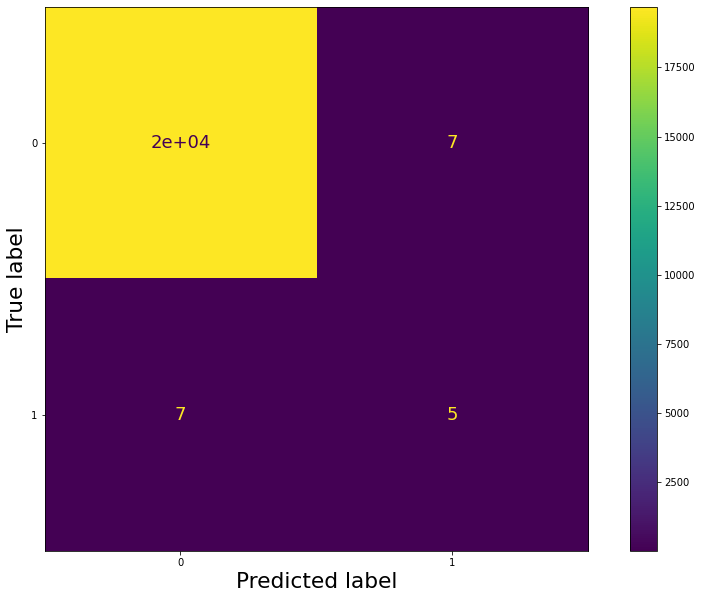

In [268]:
plot_confusion_matrix(knn_clf, x_test_scaled, y_test)

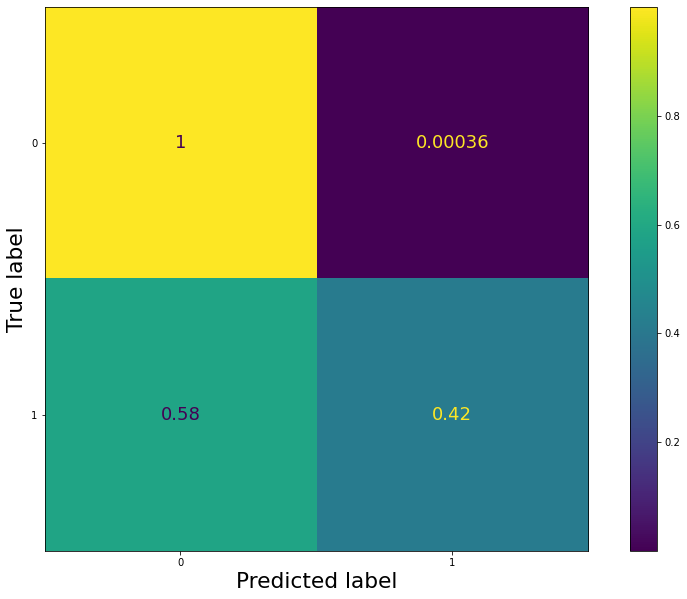

In [269]:
plot_confusion_matrix(knn_clf, x_test_scaled, y_test, normalize='true')

## Downsampling

<AxesSubplot:>

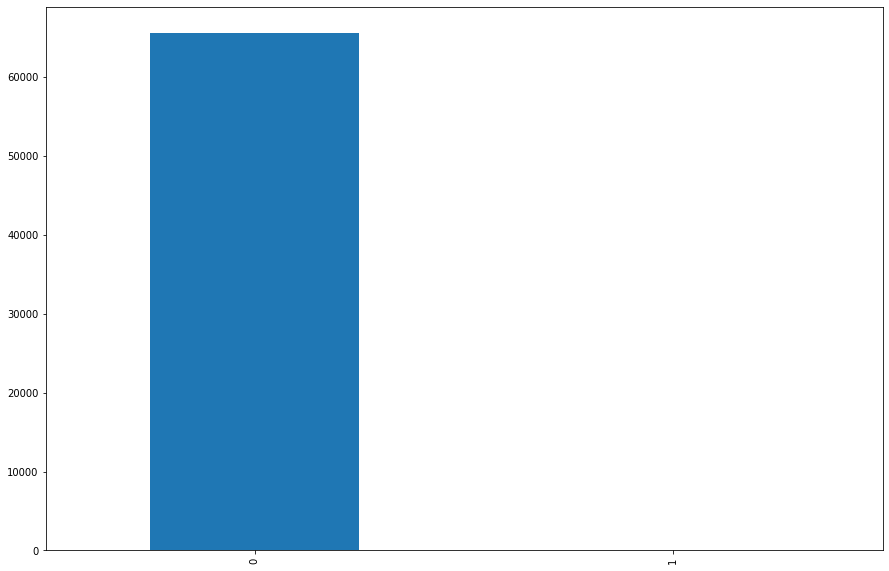

In [270]:
relations['Tagged_Relationship'].value_counts().plot.bar()

In [271]:
print('Actual Relationships:', relations['Tagged_Relationship'].value_counts()[1])
print('Not Relationships:', relations['Tagged_Relationship'].value_counts()[0])
print('Ratio of non to true: ', int(relations['Tagged_Relationship'].value_counts()[0]/relations['Tagged_Relationship'].value_counts()[1]), ':1', sep='')

Actual Relationships: 42
Not Relationships: 65626
Ratio of non to true: 1562:1


In [272]:
def create_downsample(training_df, features, target_variable, ratio_of_majority_to_minority):

    df = training_df[[target_variable] + features]
    
    negative = df[df[target_variable]==0]
    positive = df[df[target_variable]==1]

    negative_downsampled = resample(negative,
                                replace = False, # sample without replacement
                                n_samples = len(positive)*ratio_of_majority_to_minority, 
                                random_state = 0, stratify=negative['Document']) 
    # combine minority and downsampled majority
    downsampled = pd.concat([negative_downsampled, positive])
    
    print(downsampled[target_variable].value_counts())
                      
    return downsampled

In [273]:
downsample1to1 = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 1)
downsample2to1 = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 2)
downsample5to1 = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 5)
downsample10to1 = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 10)
downsample50to1 = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 50)
downsample100to1 = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 100)

0    30
1    30
Name: Tagged_Relationship, dtype: int64
0    60
1    30
Name: Tagged_Relationship, dtype: int64
0    150
1     30
Name: Tagged_Relationship, dtype: int64
0    300
1     30
Name: Tagged_Relationship, dtype: int64
0    1500
1      30
Name: Tagged_Relationship, dtype: int64
0    3000
1      30
Name: Tagged_Relationship, dtype: int64


In [274]:
downsamples=[downsample100to1, downsample50to1, downsample10to1, downsample5to1, downsample2to1]
samplenames = ['downsample100to1', 'downsample50to1', 'downsample10to1', 'downsample5to1', 'downsample2to1']

In [275]:
model = []
sample = []
Precision = []
Recall = []
F1 = []

model.append('LGBM - Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[features_raw], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM-'+name)
#     print('LGBM with', name)
#     print('-------------------------')
    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[features_raw], ds_y_train)
#     y_pred_ds_lgbm_val = ds_lgbm_clf.predict(ds_x_val[features_raw])
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees - Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[features_raw], y_train)
y_pred_et = et_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']
    
    
    model.append('Extra Trees - '+ name)

    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[features_raw], ds_y_train)
#     y_pred_ds_et_val = ds_et_clf.predict(ds_x_val[features_raw])
    y_pred_ds_et_test = ds_et_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest - Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[features_raw], y_train)
y_pred_rf = rf_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']
    

    
    model.append('Random Forest - '+ name)
#     print('Extra Trees Classifier with', name)
#     print('--------------------------------------------')
    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[features_raw], ds_y_train)
#     y_pred_ds_rf_val = ds_rf_clf.predict(ds_x_val[features_raw])
    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[features_raw])

    
    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))

In [276]:
model = []
sampling = []
Precision = []
Recall = []
F1 = []

model.append('LGBM')
sampling.append('Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[features_raw], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM')
    sampling.append(name)

    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees')
sampling.append('Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[features_raw], y_train)
y_pred_et = et_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']
    
    model.append('Extra Trees')
    sampling.append(name)
    
    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_et_test = ds_et_clf.predict(x_test[features_raw])


    
    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest')
sampling.append('Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[features_raw], y_train)
y_pred_rf = rf_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']

    
    model.append('Random Forest')
    sampling.append(name)

    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[features_raw])

    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))

In [277]:
pd.DataFrame({'Model':model, 'Sample':sampling, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False)

,Model,Sample,Precision,Recall,F1
13,Random Forest,downsample100to1,0.239130,0.916667,0.379310
7,Extra Trees,downsample100to1,0.239130,0.916667,0.379310
2,LGBM,downsample50to1,0.215686,0.916667,0.349206
0,LGBM,Full Train Sample,0.294118,0.416667,0.344828
12,Random Forest,Full Train Sample,0.294118,0.416667,0.344828
6,Extra Trees,Full Train Sample,0.294118,0.416667,0.344828
1,LGBM,downsample100to1,0.196429,0.916667,0.323529
14,Random Forest,downsample50to1,0.189655,0.916667,0.314286
8,Extra Trees,downsample50to1,0.189655,0.916667,0.314286
15,Random Forest,downsample10to1,0.093220,0.916667,0.169231


In [278]:
model = []
Precision = []
Recall = []
F1 = []

model.append('LGBM - Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[top_lgbm_features], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[top_lgbm_features])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_lgbm_features]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM-'+name)

    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[top_lgbm_features], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[top_lgbm_features])
    
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees - Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[top_lgbm_features], y_train)
y_pred_et = et_clf.predict(x_test[top_lgbm_features])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_lgbm_features]
    ds_y_train = sample['Tagged_Relationship']
    
    
    model.append('Extra Trees - '+ name)

    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[top_lgbm_features], ds_y_train)

    y_pred_ds_et_test = ds_et_clf.predict(x_test[top_lgbm_features])

    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest - Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[top_lgbm_features], y_train)
y_pred_rf = rf_clf.predict(x_test[top_lgbm_features])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_lgbm_features]
    ds_y_train = sample['Tagged_Relationship']
    
    
    model.append('Random Forest - '+ name)

    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[top_lgbm_features], ds_y_train)

    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[top_lgbm_features])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))

In [279]:
pd.DataFrame({'Model':model, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False)

,Model,Precision,Recall,F1
13,Random Forest - downsample100to1,0.244444,0.916667,0.385965
7,Extra Trees - downsample100to1,0.244444,0.916667,0.385965
2,LGBM-downsample50to1,0.229167,0.916667,0.366667
14,Random Forest - downsample50to1,0.220000,0.916667,0.354839
8,Extra Trees - downsample50to1,0.220000,0.916667,0.354839
1,LGBM-downsample100to1,0.189655,0.916667,0.314286
0,LGBM - Full Train Sample,0.266667,0.333333,0.296296
12,Random Forest - Full Train Sample,0.266667,0.333333,0.296296
6,Extra Trees - Full Train Sample,0.266667,0.333333,0.296296
15,Random Forest - downsample10to1,0.088000,0.916667,0.160584


In [280]:
top_tree_features = top_lgbm_features[:13]
top_tree_features

['max_TFISF_Species',
 'max_TFISF_Location',
 'Num_Tokens_Between',
 'Num_Verbs_Between',
 'Num_Nouns_Between',
 'Dependency_Steps',
 'Num_Words_Between',
 'Num_Preps_Between',
 'Same_Sentence',
 'inAbstract500_Species',
 'inAbstract300_Species',
 'Preposition_Between',
 'Sent_Start_Species']

In [281]:
model = []
Precision = []
Recall = []
F1 = []

model.append('LGBM - Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[top_tree_features], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[top_tree_features])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_tree_features]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM-'+name)
    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[top_tree_features], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[top_tree_features])
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees - Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[top_tree_features], y_train)
y_pred_et = et_clf.predict(x_test[top_tree_features])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_tree_features]
    ds_y_train = sample['Tagged_Relationship']
    
    model.append('Extra Trees - '+ name)
    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[top_tree_features], ds_y_train)
    y_pred_ds_et_test = ds_et_clf.predict(x_test[top_tree_features])
    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest - Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[top_tree_features], y_train)
y_pred_rf = rf_clf.predict(x_test[top_tree_features])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_tree_features]
    ds_y_train = sample['Tagged_Relationship']
    model.append('Random Forest - '+ name)
    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[top_tree_features], ds_y_train)
    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[top_tree_features])   
    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))

In [282]:
pd.DataFrame({'Model':model, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False)

,Model,Precision,Recall,F1
2,LGBM-downsample50to1,0.229167,0.916667,0.366667
13,Random Forest - downsample100to1,0.229167,0.916667,0.366667
7,Extra Trees - downsample100to1,0.229167,0.916667,0.366667
1,LGBM-downsample100to1,0.189655,0.916667,0.314286
14,Random Forest - downsample50to1,0.186441,0.916667,0.309859
8,Extra Trees - downsample50to1,0.186441,0.916667,0.309859
0,LGBM - Full Train Sample,0.166667,0.250000,0.200000
12,Random Forest - Full Train Sample,0.166667,0.250000,0.200000
6,Extra Trees - Full Train Sample,0.166667,0.250000,0.200000
15,Random Forest - downsample10to1,0.093220,0.916667,0.169231


## Cross Validation

In [283]:
scores = cross_val_score(
    lgbm_clf, X, y, cv=5, scoring='f1')
scores

array([0.03846154, 0.125     , 0.07142857, 0.33333333, 0.        ])

In [284]:
relations.Tagged_Relationship.value_counts()

0    65626
1       42
Name: Tagged_Relationship, dtype: int64

In [285]:
relations.Document.value_counts(normalize=True)

fmicb_10_01018.txt                                       0.697143
Archer2017_Article_EndolithicMicrobialDiversityIn.txt    0.280319
Fraser2018_Article_EvidenceOfPlantAndAnimalCommun.txt    0.022538
Name: Document, dtype: float64

In [286]:
for source in relations.Document.unique():
    print(source, '\n',relations[relations.Document==source].Tagged_Relationship.value_counts()[1], '/', len(relations[relations.Document==source]), '\t', 
          np.round(relations[relations.Document==source].Tagged_Relationship.value_counts(normalize = True)[1],4), '\n')

Archer2017_Article_EndolithicMicrobialDiversityIn.txt 
 24 / 18408 	 0.0013 

fmicb_10_01018.txt 
 14 / 45780 	 0.0003 

Fraser2018_Article_EvidenceOfPlantAndAnimalCommun.txt 
 4 / 1480 	 0.0027 



In [287]:
def cross_validation_with_downsample(training_df, splits, features, target_variable, ratio_of_majority_to_minority, model):
    state = 9999
    df = training_df[[target_variable]+features]
    y = np.array(df[target_variable])
    X = np.array(df[features])
    
    skf = StratifiedKFold(n_splits=splits, 
               shuffle=True, random_state=state
              )
    
    
    precision = []
    recall = []
    f1 = []
    support = []
    for train_index, test_index in skf.split(X,y):
#     for train_index, test_index in rskf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        

        df2 = pd.DataFrame(X_train, columns=features)
        df2[target_variable] = y_train
            
        negative = df2[df2[target_variable]==0]
        positive = df2[df2[target_variable]==1]

        negative_downsampled = resample(negative,
                                replace = False, # sample without replacement
                                n_samples = len(positive)*ratio_of_majority_to_minority, 
                                random_state=state) 
        
        downsampled = pd.concat([negative_downsampled, positive])
#         print(downsampled[target_variable].value_counts())
        
        y_train = np.array(downsampled[target_variable])
        X_train = np.array(downsampled[features])
#         print(X_train.shape, y_train.shape)
#         print(pd.Series(y_train).value_counts())

    
        if model == 'lgbm':
            clf = lgbm.LGBMClassifier(random_state=state)
        elif model == 'RandomForest':
            clf = RandomForestClassifier(random_state=state)
        elif model == 'ExtraTrees':
            clf = ExtraTreesClassifier(random_state=state)
            
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        
        
        metric_array = metrics.precision_recall_fscore_support(y_test, y_pred, average='binary')[0:3]
        precision.append(metric_array[0])
        recall.append(metric_array[1])
        f1.append(metric_array[2])
    
    stats = {'Precision': precision, 'Recall':recall,'F1':f1,}
    
    cross_val_df = pd.DataFrame(stats)
    cross_val_df.index.name='Fold'
    cross_val_df = cross_val_df.transpose()
    cross_val_df['Cross-Val Mean'] = cross_val_df.apply(np.mean, axis = 1)

    return cross_val_df

In [288]:
skf = StratifiedKFold(n_splits=5, 
               shuffle=True
              )

In [289]:
cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'lgbm')

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.315789,0.181818,0.037037,0.285714,0.347826,0.233637
Recall,0.750000,0.666667,0.111111,1.000000,1.000000,0.705556
F1,0.444444,0.285714,0.055556,0.444444,0.516129,0.349258


In [290]:
def cross_validation_no_downsample(training_df, splits, features, target_variable, model):
    state = 9999
    df = training_df[[target_variable]+features]
    y = np.array(df[target_variable])
    X = np.array(df[features])
    
    skf = StratifiedKFold(n_splits=splits, 
               shuffle=True, random_state=state
              )
    skf.get_n_splits(X, y) 
    
    precision = []
    recall = []
    f1 = []
    support = []
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        if model == 'lgbm':
            clf = lgbm.LGBMClassifier(random_state=state)
        elif model == 'RandomForest':
            clf = RandomForestClassifier(random_state=state)
        elif model == 'ExtraTrees':
            clf = ExtraTreesClassifier(random_state=state)
            
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        
        
        metric_array = metrics.precision_recall_fscore_support(y_test, y_pred, average='binary')[0:3]
        precision.append(metric_array[0])
        recall.append(metric_array[1])
        f1.append(metric_array[2])
    
    stats = {'Precision': precision, 'Recall':recall,'F1':f1,}
    
    cross_val_df = pd.DataFrame(stats)
    cross_val_df.index.name='Fold'
    cross_val_df = cross_val_df.transpose()
    cross_val_df['Cross-Val Mean'] = cross_val_df.apply(np.mean, axis = 1)

    return cross_val_df

In [291]:
lgbmfull = cross_validation_no_downsample(relations, 5, features_raw, 'Tagged_Relationship', 'lgbm')
lgbmfull

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.0,0.016949,0.0,0.105263,0.003083,0.025059
Recall,0.0,0.666667,0.0,0.250000,0.625000,0.308333
F1,0.0,0.033058,0.0,0.148148,0.006135,0.037468


In [292]:
lgbmfull['Cross-Val Mean'][0]

0.025058984898765964

In [293]:
lgbm100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'lgbm')
lgbm100

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.315789,0.181818,0.037037,0.285714,0.347826,0.233637
Recall,0.750000,0.666667,0.111111,1.000000,1.000000,0.705556
F1,0.444444,0.285714,0.055556,0.444444,0.516129,0.349258


In [294]:
lgbm50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'lgbm')
lgbm50

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.122449,0.194444,0.041667,0.25,0.133333,0.148379
Recall,0.750000,0.777778,0.222222,1.00,1.000000,0.750000
F1,0.210526,0.311111,0.070175,0.40,0.235294,0.245421


In [295]:
lgbm20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'lgbm')
lgbm20

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.086420,0.074766,0.113636,0.103896,0.094118,0.094567
Recall,0.875000,0.888889,0.555556,1.000000,1.000000,0.863889
F1,0.157303,0.137931,0.188679,0.188235,0.172043,0.168838


In [296]:
lgbm10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'lgbm')
lgbm10

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.067961,0.054878,0.033784,0.051948,0.114286,0.064571
Recall,0.875000,1.000000,0.555556,1.000000,1.000000,0.886111
F1,0.126126,0.104046,0.063694,0.098765,0.205128,0.119552


In [297]:
lgbm5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'lgbm')
lgbm5

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.049645,0.022277,0.025000,0.035714,0.046784,0.035884
Recall,0.875000,1.000000,0.444444,1.000000,1.000000,0.863889
F1,0.093960,0.043584,0.047337,0.068966,0.089385,0.068646


In [298]:
lgbm2 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 2, 'lgbm')
lgbm2

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.033654,0.015101,0.030418,0.017582,0.035714,0.026494
Recall,0.875000,1.000000,0.888889,1.000000,1.000000,0.952778
F1,0.064815,0.029752,0.058824,0.034557,0.068966,0.051383


In [299]:
rffull = cross_validation_no_downsample(relations, 5, features_raw, 'Tagged_Relationship', 'RandomForest')
rffull

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.600000,0.428571,0.0,0.400000,1.000000,0.485714
Recall,0.375000,0.333333,0.0,0.250000,0.750000,0.341667
F1,0.461538,0.375000,0.0,0.307692,0.857143,0.400275


In [300]:
rf100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'RandomForest')
rf100

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.318182,0.241379,0.181818,0.400000,0.285714,0.285419
Recall,0.875000,0.777778,0.444444,1.000000,1.000000,0.819444
F1,0.466667,0.368421,0.258065,0.571429,0.444444,0.421805


In [301]:
rf50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'RandomForest')
rf50

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.21875,0.205882,0.181818,0.228571,0.210526,0.209110
Recall,0.87500,0.777778,0.666667,1.000000,1.000000,0.863889
F1,0.35000,0.325581,0.285714,0.372093,0.347826,0.336243


In [302]:
rf20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'RandomForest')
rf20

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.101449,0.086420,0.160000,0.101266,0.119403,0.113708
Recall,0.875000,0.777778,0.888889,1.000000,1.000000,0.908333
F1,0.181818,0.155556,0.271186,0.183908,0.213333,0.201160


In [303]:
rf10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'RandomForest')
rf10

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.078652,0.055944,0.080357,0.065041,0.093023,0.074603
Recall,0.875000,0.888889,1.000000,1.000000,1.000000,0.952778
F1,0.144330,0.105263,0.148760,0.122137,0.170213,0.138141


In [304]:
rf5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'RandomForest')
rf5

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.041916,0.041237,0.070866,0.038462,0.075472,0.053591
Recall,0.875000,0.888889,1.000000,1.000000,1.000000,0.952778
F1,0.080000,0.078818,0.132353,0.074074,0.140351,0.101119


In [305]:
rf2 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 2, 'RandomForest')
rf2

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.024055,0.024862,0.040909,0.031008,0.032389,0.030644
Recall,0.875000,1.000000,1.000000,1.000000,1.000000,0.975000
F1,0.046823,0.048518,0.078603,0.060150,0.062745,0.059368


In [306]:
etfull = cross_validation_no_downsample(relations, 5, features_raw, 'Tagged_Relationship', 'ExtraTrees')
etfull

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.500000,0.555556,0.0,0.428571,0.833333,0.463492
Recall,0.250000,0.555556,0.0,0.375000,0.625000,0.361111
F1,0.333333,0.555556,0.0,0.400000,0.714286,0.400635


In [307]:
et100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'ExtraTrees')
et100

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.181818,0.250000,0.181818,0.347826,0.320000,0.256292
Recall,0.750000,0.777778,0.444444,1.000000,1.000000,0.794444
F1,0.292683,0.378378,0.258065,0.516129,0.484848,0.386021


In [308]:
et50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'ExtraTrees')
et50

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.155556,0.179487,0.185185,0.242424,0.216216,0.195774
Recall,0.875000,0.777778,0.555556,1.000000,1.000000,0.841667
F1,0.264151,0.291667,0.277778,0.390244,0.355556,0.315879


In [309]:
et20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'ExtraTrees')
et20

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.106061,0.109375,0.106061,0.137931,0.114286,0.114743
Recall,0.875000,0.777778,0.777778,1.000000,1.000000,0.886111
F1,0.189189,0.191781,0.186667,0.242424,0.205128,0.203038


In [310]:
et10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'ExtraTrees')
et10

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.085366,0.065217,0.049180,0.083333,0.112676,0.079155
Recall,0.875000,1.000000,0.666667,1.000000,1.000000,0.908333
F1,0.155556,0.122449,0.091603,0.153846,0.202532,0.145197


In [311]:
et5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'ExtraTrees')
et5

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.060870,0.052941,0.050000,0.056338,0.084211,0.060872
Recall,0.875000,1.000000,0.777778,1.000000,1.000000,0.930556
F1,0.113821,0.100559,0.093960,0.106667,0.155340,0.114069


In [312]:
et2 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 2, 'ExtraTrees')
et2

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.030172,0.029605,0.031873,0.026846,0.052632,0.034225
Recall,0.875000,1.000000,0.888889,1.000000,1.000000,0.952778
F1,0.058333,0.057508,0.061538,0.052288,0.100000,0.065933


In [313]:
modellist = ['lgbm', 'RandomForest', 'ExtraTrees']
modelNames = ['LGBM', 'Random Forest', 'Extra Trees']
downsamples =[100, 50, 20, 10, 5, 2]
model = []
sampling = []
Precision = []
Recall = []
F1 = []

for i, modeltype in enumerate(modellist):
    model.append(modelNames[i])
    sampling.append('Full Train Sample')
    results = cross_validation_no_downsample(relations,5,features_raw,'Tagged_Relationship', modeltype)
    F1.append(results['Cross-Val Mean'][2])
    Recall.append(results['Cross-Val Mean'][1])
    Precision.append(results['Cross-Val Mean'][0])
    
    for size in downsamples:
        model.append(modelNames[i])
        sampling.append('Downsample '+ str(size)+ ' to 1')
        results = cross_validation_with_downsample(relations,5,features_raw,'Tagged_Relationship', size, modeltype)
        F1.append(results['Cross-Val Mean'][2])
        Recall.append(results['Cross-Val Mean'][1])
        Precision.append(results['Cross-Val Mean'][0])

                     
crossValResults = pd.DataFrame({'Model':model, 'Sample':sampling, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False)

In [314]:
crossValResults

,Model,Sample,Precision,Recall,F1
8,Random Forest,Downsample 100 to 1,0.285419,0.819444,0.421805
14,Extra Trees,Full Train Sample,0.463492,0.361111,0.400635
7,Random Forest,Full Train Sample,0.485714,0.341667,0.400275
15,Extra Trees,Downsample 100 to 1,0.256292,0.794444,0.386021
1,LGBM,Downsample 100 to 1,0.233637,0.705556,0.349258
9,Random Forest,Downsample 50 to 1,0.209110,0.863889,0.336243
16,Extra Trees,Downsample 50 to 1,0.195774,0.841667,0.315879
2,LGBM,Downsample 50 to 1,0.148379,0.750000,0.245421
17,Extra Trees,Downsample 20 to 1,0.114743,0.886111,0.203038
10,Random Forest,Downsample 20 to 1,0.113708,0.908333,0.201160


In [315]:
ratio = {'Full Train Sample':165, 'Downsample 100 to 1':100, 'Downsample 50 to 1':50,
       'Downsample 20 to 1':20, 'Downsample 10 to 1':10, 'Downsample 5 to 1':5,
       'Downsample 2 to 1':2}
crossValResults['Sample Ratio']=crossValResults['Sample'].map(ratio)

In [316]:
crossValResults

,Model,Sample,Precision,Recall,F1,Sample Ratio
8,Random Forest,Downsample 100 to 1,0.285419,0.819444,0.421805,100
14,Extra Trees,Full Train Sample,0.463492,0.361111,0.400635,165
7,Random Forest,Full Train Sample,0.485714,0.341667,0.400275,165
15,Extra Trees,Downsample 100 to 1,0.256292,0.794444,0.386021,100
1,LGBM,Downsample 100 to 1,0.233637,0.705556,0.349258,100
9,Random Forest,Downsample 50 to 1,0.209110,0.863889,0.336243,50
16,Extra Trees,Downsample 50 to 1,0.195774,0.841667,0.315879,50
2,LGBM,Downsample 50 to 1,0.148379,0.750000,0.245421,50
17,Extra Trees,Downsample 20 to 1,0.114743,0.886111,0.203038,20
10,Random Forest,Downsample 20 to 1,0.113708,0.908333,0.201160,20


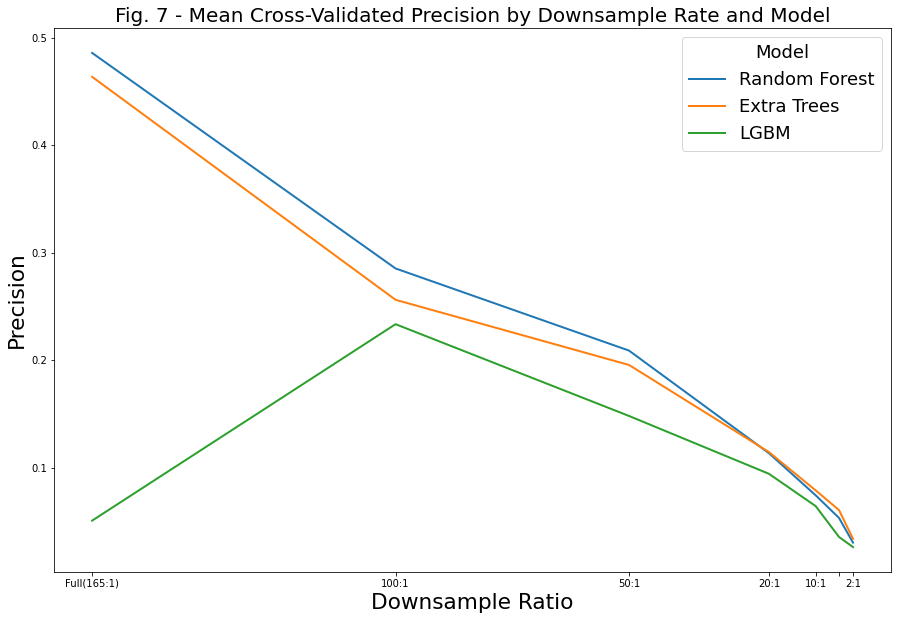

In [317]:
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample Ratio', y='Precision', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Fig. 7 - Mean Cross-Validated Precision by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.show()

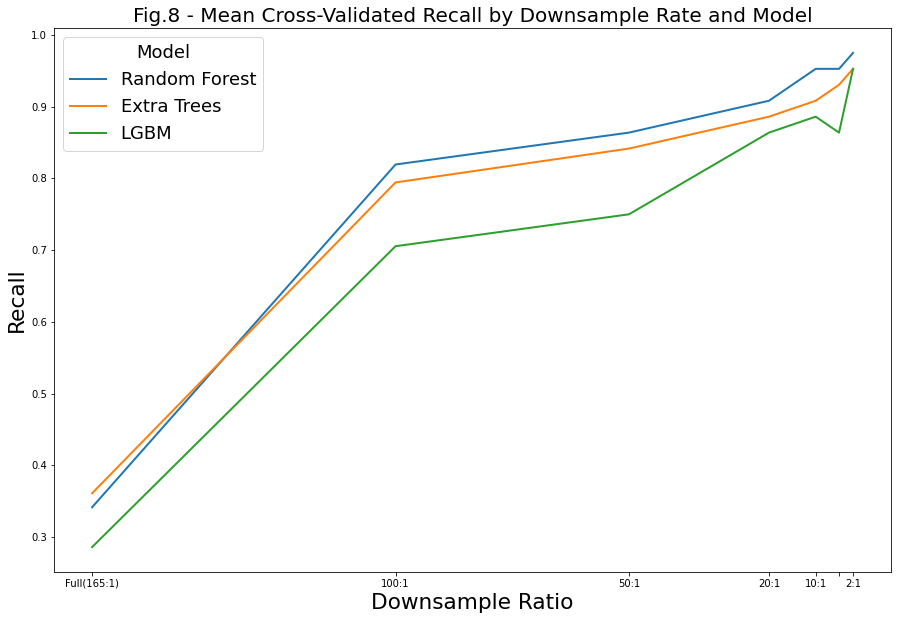

In [318]:
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample Ratio', y='Recall', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Fig.8 - Mean Cross-Validated Recall by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.show()

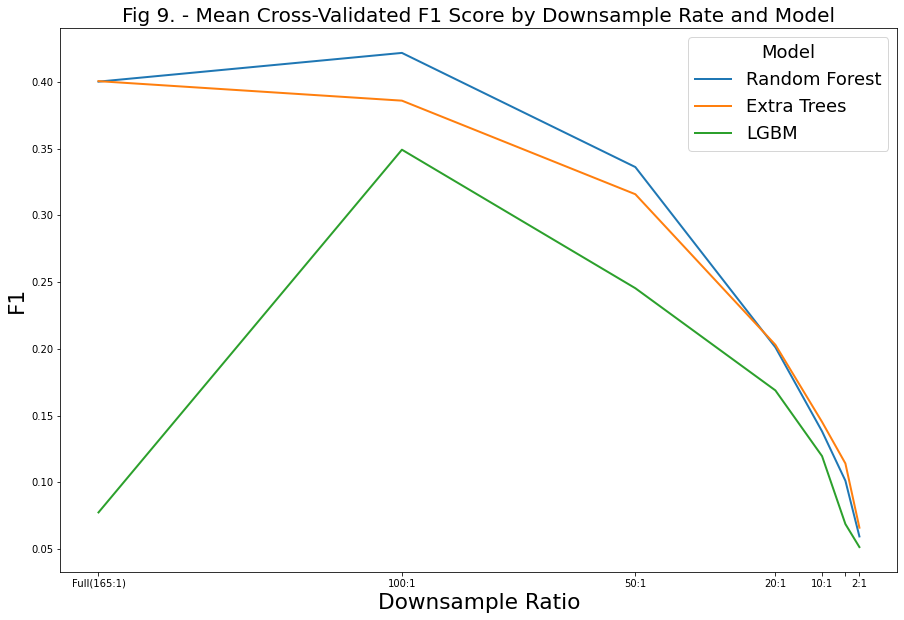

In [319]:
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample Ratio', y='F1', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Fig 9. - Mean Cross-Validated F1 Score by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.show()

In [339]:
cols = list(crossValResults.columns[2:])
crossValResults[cols] = crossValResults[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [341]:
crossValResultsShort = crossValResults.head(12)

In [342]:
crossValResults2 = crossValResults.tail(21).reset_index(drop=True)

In [348]:
crossValResults2.head(12).reset_index(drop=True, inplace=True)

In [349]:
crossValResultsShort.reset_index(drop=True, inplace=True)

In [350]:

crossValResults2.head(12) == crossValResultsShort


,Model,Sample,Precision,Recall,F1,Sample Ratio
0,True,True,True,True,True,True
1,True,True,True,True,True,True
2,True,True,True,True,True,True
3,True,True,True,True,True,True
4,True,True,True,True,True,True
5,True,True,True,True,True,True
6,True,True,True,True,True,True
7,True,True,True,True,True,True
8,True,True,True,True,True,True
9,True,True,True,True,True,True


In [351]:
crossValResults = crossValResults2

In [354]:
crossValResults.to_csv('Models\\crossValResults.csv')
crossValResultsShort.to_csv('Models\\crossValResultsShort.csv')

In [355]:
crossValResults = pd.read_csv('Models\\crossValResults.csv')
crossValResultsShort = pd.read_csv('Models\\crossValResultsShort.csv')

In [356]:
crossValResults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    21 non-null     int64  
 1   Unnamed: 0.1  21 non-null     int64  
 2   Model         21 non-null     object 
 3   Sample        21 non-null     object 
 4   Precision     21 non-null     float64
 5   Recall        21 non-null     float64
 6   F1            21 non-null     float64
 7   Sample Ratio  21 non-null     float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.4+ KB


In [357]:
crossValResults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    21 non-null     int64  
 1   Unnamed: 0.1  21 non-null     int64  
 2   Model         21 non-null     object 
 3   Sample        21 non-null     object 
 4   Precision     21 non-null     float64
 5   Recall        21 non-null     float64
 6   F1            21 non-null     float64
 7   Sample Ratio  21 non-null     float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.4+ KB


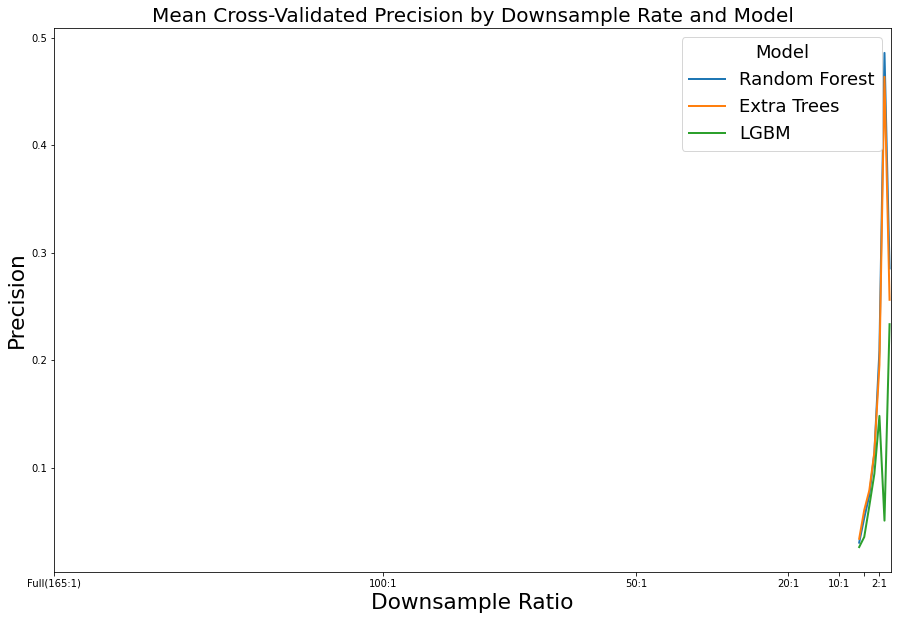

In [358]:
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Precision', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Precision by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.show()

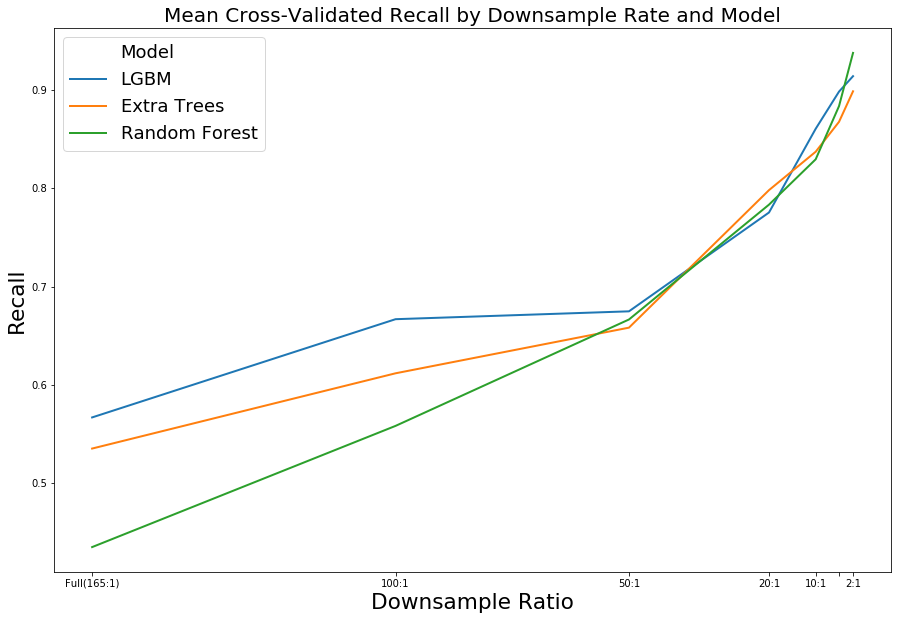

In [78]:
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Recall', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Recall by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.show()

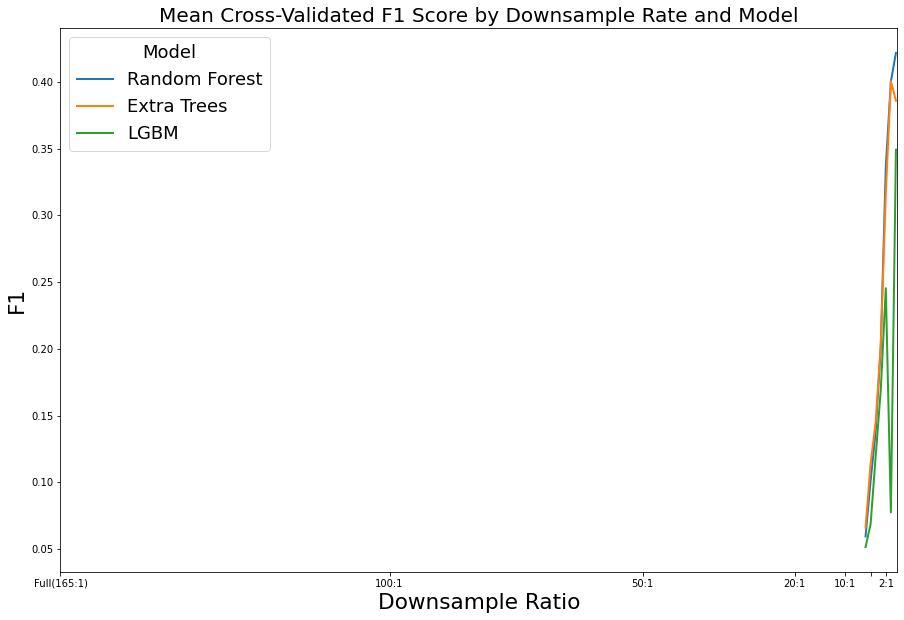

In [359]:
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='F1', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated F1 Score by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.show()

## Revised Plots for GIS Paper

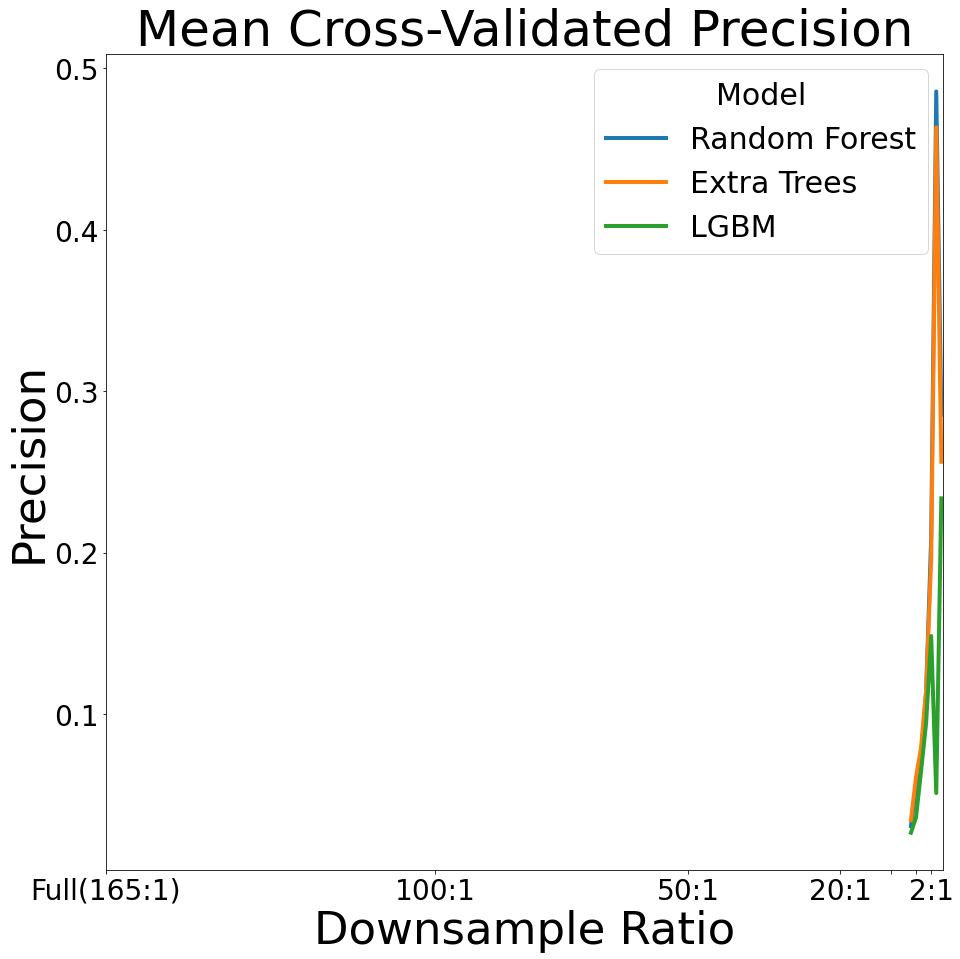

In [360]:
# plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 15
rcParams['axes.titlesize'] = 50
rcParams['axes.labelsize'] = 45
rcParams['xtick.labelsize'] = 28
rcParams['ytick.labelsize'] = 28
rcParams['lines.linewidth'] = 4
rcParams['font.size'] = 18
rcParams['legend.fontsize'] = 30
rcParams['legend.title_fontsize'] = 30
# rcParams['axes.legend]
ax = sns.lineplot(x='Sample', y='Precision', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Precision')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '','', '2:1'])
ax.set_xlabel('Downsample Ratio')
# ax.legend(fontsize="large")
plt.savefig('Fig2Precision.pdf', format='pdf', dpi=300)
plt.show()

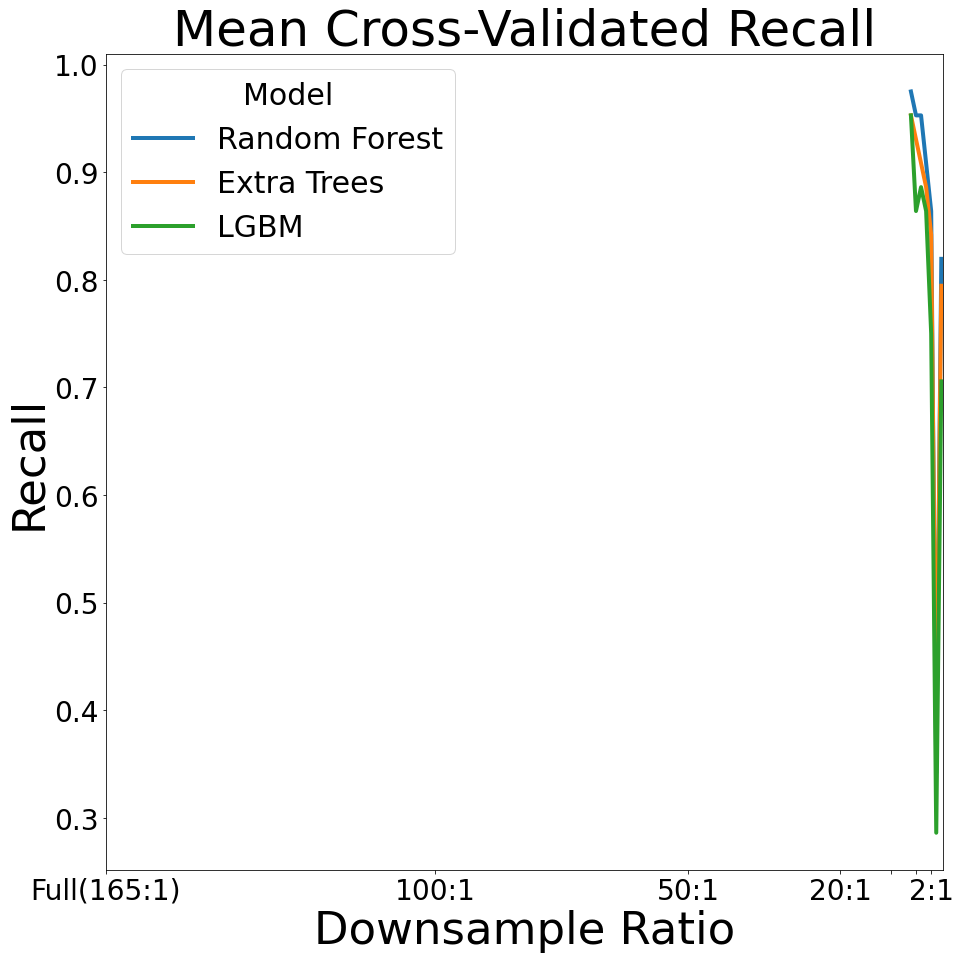

In [361]:
# plt.figure(figsize=(15, 10))
# rcParams['figure.figsize'] = 15, 10
# rcParams['axes.titlesize'] = 20
# rcParams['axes.labelsize'] = 'large'
# rcParams['xtick.labelsize'] = 10
# rcParams['ytick.labelsize'] = 10
# rcParams['lines.linewidth'] = 2
# rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Recall', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Recall')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig('Fig2Recall.pdf', format='pdf', dpi=300)
plt.show()

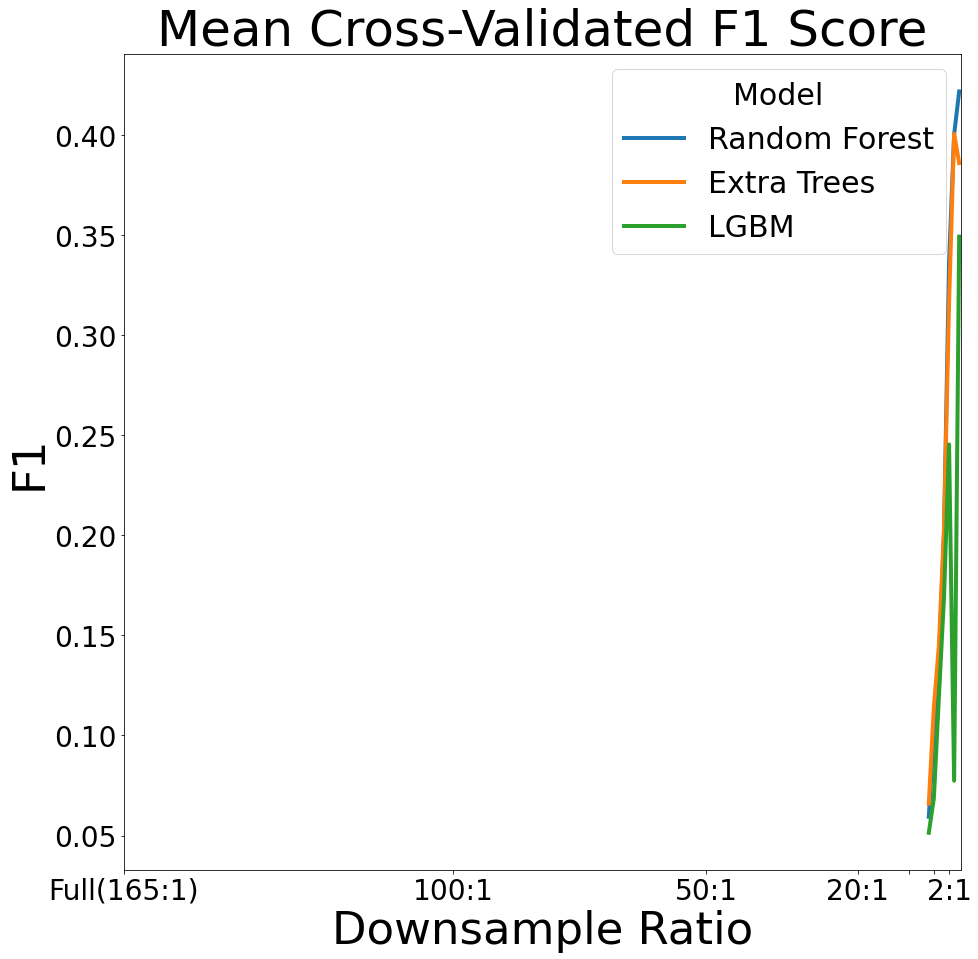

In [362]:
# plt.figure(figsize=(15, 10))
# rcParams['figure.figsize'] = 15, 10
# rcParams['axes.titlesize'] = 20
# rcParams['axes.labelsize'] = 'large'
# rcParams['xtick.labelsize'] = 10
# rcParams['ytick.labelsize'] = 10
# rcParams['lines.linewidth'] = 2
# rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='F1', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated F1 Score')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig('Fig2F1.pdf', format='pdf', dpi=300)
plt.show()

In [363]:
crossValResultsShort

,Unnamed: 0,Unnamed: 0.1,Model,Sample,Precision,Recall,F1,Sample Ratio
0,0,0,Random Forest,Downsample 100 to 1,0.285419,0.819444,0.421805,100.0
1,1,1,Extra Trees,Full Train Sample,0.463492,0.361111,0.400635,165.0
2,2,2,Random Forest,Full Train Sample,0.485714,0.341667,0.400275,165.0
3,3,3,Extra Trees,Downsample 100 to 1,0.256292,0.794444,0.386021,100.0
4,4,4,LGBM,Downsample 100 to 1,0.233637,0.705556,0.349258,100.0
5,5,5,Random Forest,Downsample 50 to 1,0.209110,0.863889,0.336243,50.0
6,6,6,Extra Trees,Downsample 50 to 1,0.195774,0.841667,0.315879,50.0
7,7,7,LGBM,Downsample 50 to 1,0.148379,0.750000,0.245421,50.0
8,8,8,Extra Trees,Downsample 20 to 1,0.114743,0.886111,0.203038,20.0
9,9,9,Random Forest,Downsample 20 to 1,0.113708,0.908333,0.201160,20.0


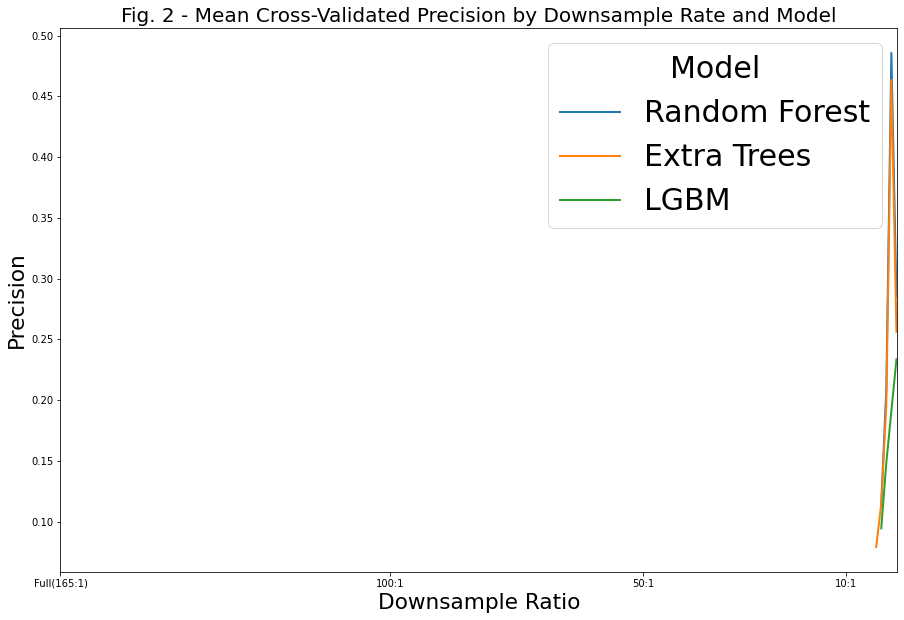

In [364]:
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Precision', hue='Model', data = crossValResultsShort)
ax.invert_xaxis()
ax.set_title('Fig. 2 - Mean Cross-Validated Precision by Downsample Rate and Model')
ax.set_xticks([165, 100,50,10])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '10:1'])
ax.set_xlabel('Downsample Ratio')
plt.show()

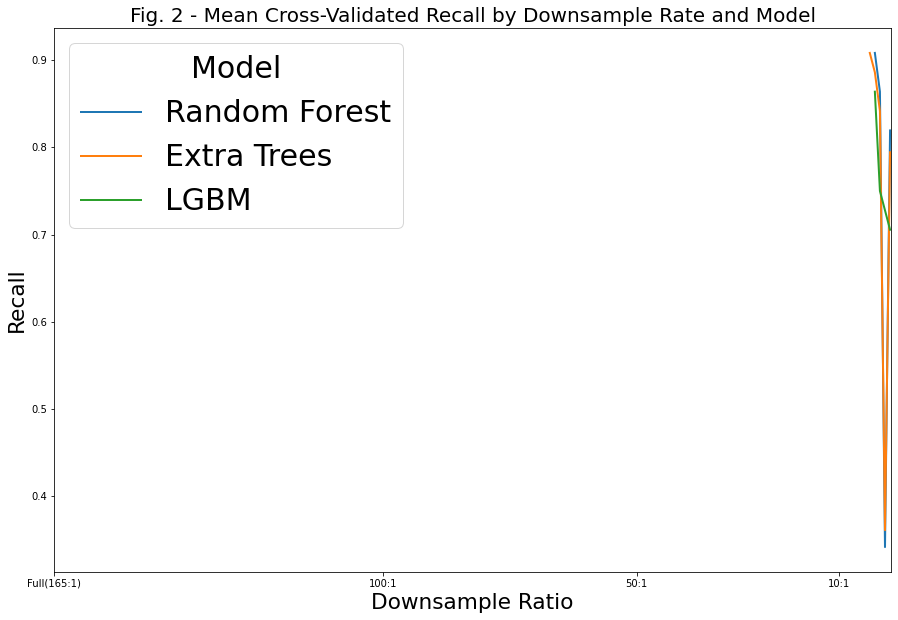

In [365]:
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Recall', hue='Model', data = crossValResultsShort)
ax.invert_xaxis()
ax.set_title('Fig. 2 - Mean Cross-Validated Recall by Downsample Rate and Model')
ax.set_xticks([165, 100,50,10])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '10:1'])
ax.set_xlabel('Downsample Ratio')
plt.show()

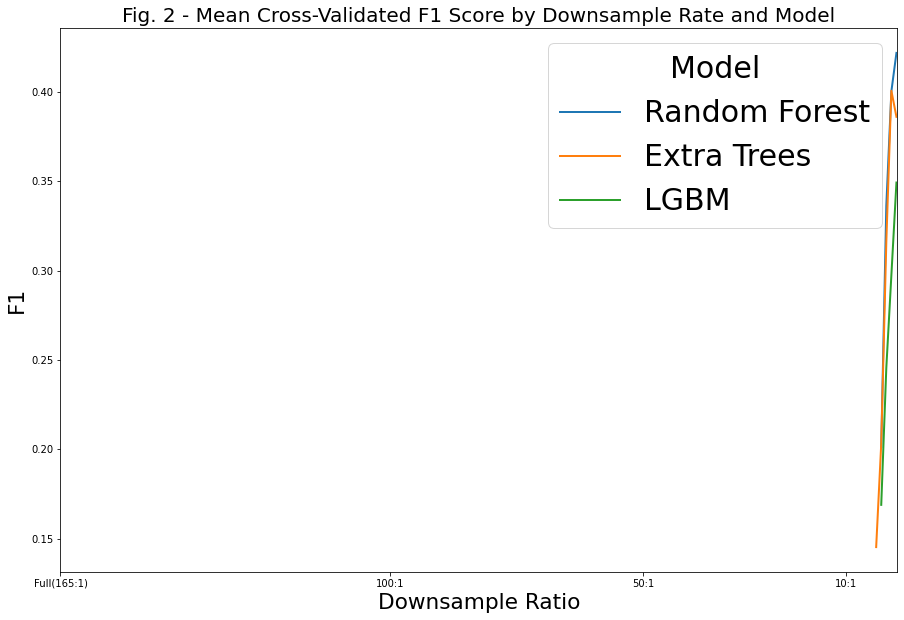

In [366]:
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='F1', hue='Model', data = crossValResultsShort)
ax.invert_xaxis()
ax.set_title('Fig. 2 - Mean Cross-Validated F1 Score by Downsample Rate and Model')
ax.set_xticks([165, 100,50,10])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '10:1'])
ax.set_xlabel('Downsample Ratio')
plt.show()

End.